# 📊 Proyecto Final de Estadística (MATCOM, UH) — Curso 2025–2026  
## Análisis Cuantitativo de Mercados Financieros (Acciones vs ETF de Oro)

**Equipo:** Juan Carlos Carmenate Díaz y Sebastian González Alfonso  
> **Fecha:** 12 de enero de 2026

Este notebook implementa las fases exigidas en la guía del proyecto:  
- **1** Definición del problema y recopilación de datos
- **2** Análisis Exploratorio de Datos (EDA)
- **3** Preparación de datos
- **4** Aplicación de Técnicas estadísticas
- **5** Resultados y Conclusiones.

> Guía del proyecto: *Orden.pdf*.

## 0. Preparación del entorno

En este trabajo se emplean bibliotecas estándar de análisis de datos en Python: `numpy`, `pandas`, `matplotlib`, `seaborn`, `scipy` y `scikit-learn`.

In [73]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score, mean_squared_error,
    accuracy_score, confusion_matrix, classification_report
)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

---

## 1. Definición del Problema y Recopilación de Datos

### 📌 Problema
Los mercados financieros presentan **volatilidad**, **correlaciones** entre activos y **patrones temporales**. A partir de series históricas diarias, podemos aplicar técnicas estadísticas para comparar comportamiento, riesgo y relaciones entre activos.

### ❓ Preguntas de investigación
1. **¿Qué activo presenta mayor volatilidad** en el período analizado?  
2. **¿Existen correlaciones significativas** entre los rendimientos de los activos?  
3. **¿Se pueden identificar grupos (clusters)** de activos según su comportamiento estadístico?  
4. **¿Se puede predecir la dirección diaria** (sube/baja) de un activo usando variables simples?

### 📂 Datos
Se utilizan archivos CSV descargados y adjuntos al proyecto:

- **AAPL** (acción) — Apple Inc.  
- **MSFT** (acción) — Microsoft Corporation  
- **NVDA** (acción) — NVIDIA Corporation  
- **AAAU** (ETF) — Gold ETF respaldado por oro  

**Variables típicas en los CSV:** 
- `Date`: Fecha del evento, 
- `Open`: Precio de apertura de la acción, 
- `High`: Mayor valor alcanzado por la acción en el día,
- `Low`: Menor valor alcanzado por la acción en el día,
- `Close`: Precio de cierre de la acción,
- `Adj Close`: Precio de cierre de la acción ajustado para reflejar eventos corporativos y ser comparable en el tiempo, 
- `Volume`: Número de unidades (acciones o ETF) intercambidas en el día que refleja la actividad del mercado.

### 1.1. Recopilación de datos

> Si tus CSV están dentro de una carpeta `data/`, cambia `DATA_DIR` a `"data"`.

In [74]:
from pathlib import Path

DATA_DIR = Path("data")  # o "data"

files = {
    "AAPL": DATA_DIR / "AAPL.csv",
    "MSFT": DATA_DIR / "MSFT.csv",
    "NVDA": DATA_DIR / "NVDA.csv",
    "AAAU": DATA_DIR / "AAAU.csv",
}

for k, p in files.items():
    if not p.exists():
        raise FileNotFoundError(f"No se encuentra {p}. Ajusta DATA_DIR o el nombre del archivo.")

def load_asset(symbol: str, path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Normalizar nombres comunes
    if "Date" not in df.columns:
        raise ValueError(f"{symbol}: no existe columna 'Date'. Columnas: {list(df.columns)}")
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").drop_duplicates(subset=["Date"])

    # Algunas fuentes usan 'Adj Close' y otras 'Adj_Close'
    if "Adj Close" not in df.columns and "Adj_Close" in df.columns:
        df = df.rename(columns={"Adj_Close":"Adj Close"})

    # Asegurar que precios/volumen sean numéricos
    for col in ["Open","High","Low","Close","Adj Close","Volume"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df.reset_index(drop=True)

assets = {sym: load_asset(sym, path) for sym, path in files.items()}
{k: v.head(3) for k, v in assets.items()}

{'AAPL':         Date      Open      High       Low     Close  Adj Close     Volume
 0 1980-12-12  0.513393  0.515625  0.513393  0.513393   0.406782  117258400
 1 1980-12-15  0.488839  0.488839  0.486607  0.486607   0.385558   43971200
 2 1980-12-16  0.453125  0.453125  0.450893  0.450893   0.357260   26432000,
 'MSFT':         Date      Open      High       Low     Close  Adj Close      Volume
 0 1986-03-13  0.088542  0.101562  0.088542  0.097222   0.062378  1031788800
 1 1986-03-14  0.097222  0.102431  0.097222  0.100694   0.064606   308160000
 2 1986-03-17  0.100694  0.103299  0.100694  0.102431   0.065720   133171200,
 'NVDA':         Date      Open      High       Low     Close  Adj Close      Volume
 0 1999-01-22  1.750000  1.953125  1.552083  1.640625   1.509998  67867200.0
 1 1999-01-25  1.770833  1.833333  1.640625  1.812500   1.668188  12762000.0
 2 1999-01-26  1.833333  1.869792  1.645833  1.671875   1.538759   8580000.0,
 'AAAU':         Date   Open   High    Low  Close  Ad

### 1.2. Revisión rápida (calidad y rango temporal)

In [75]:
summary = []
for sym, df in assets.items():
    summary.append({
        "Asset": sym,
        "Rows": len(df),
        "Start": df["Date"].min().date(),
        "End": df["Date"].max().date(),
        "Missing_Close": int(df["Close"].isna().sum()) if "Close" in df.columns else None,
        "Missing_AdjClose": int(df["Adj Close"].isna().sum()) if "Adj Close" in df.columns else None,
        "Missing_Volume": int(df["Volume"].isna().sum()) if "Volume" in df.columns else None,
    })
pd.DataFrame(summary)

,Asset,Rows,Start,End,Missing_Close,Missing_AdjClose,Missing_Volume
0,AAPL,9909,1980-12-12,2020-04-01,0,0,0
1,MSFT,8584,1986-03-13,2020-04-01,0,0,0
2,NVDA,5334,1999-01-22,2020-04-01,1,1,1
3,AAAU,410,2018-08-15,2020-04-01,0,0,0


### 1.2.1 Consideraciones sobre Cobertura Temporal

Como se observa en la tabla anterior, **AAAU** posee el historial más corto (410 filas, 2018-08-15 a 2020-04-01), 
mientras que **AAPL**, **MSFT** y **NVDA** tienen datos históricos que se remontan a décadas. Para garantizar comparabilidad 
y simultaneidad en análisis multivariados (correlaciones, PCA, clustering, clasificación), todas las técnicas 
se aplicarán sobre la intersección temporal, es decir, fechas donde existen observaciones válidas para 
los cuatro activos simultáneamente.

Esto resulta en un período de análisis efectivo de **409 observaciones diarias** (2018-08-15 a 2020-04-01), 
que coincide con un sub-período de volatilidad moderada a alta (incluye la caída de marzo de 2020 por COVID-19). 
Por tanto, las conclusiones obtenidas deben interpretarse en el contexto de este sub-período específico y pueden no 
generalizarse a períodos más largos o diferentes ciclos económicos.

---

## 2. Análisis Exploratorio de Datos (EDA)

En finanzas, el análisis se hace típicamente sobre **rendimientos** en lugar de precios. Aquí usaremos:

- Rendimiento simple: $ r_t = \frac{P_t - P_{t-1}}{P_{t-1}} $

- Rendimiento logarítmico: $ \ell_t = \ln(P_t) - \ln(P_{t-1}) $

Trabajaremos con `Adj Close` si está disponible; en caso contrario, `Close`.

In [76]:
def pick_price_col(df: pd.DataFrame) -> str:
    return "Adj Close" if "Adj Close" in df.columns and df["Adj Close"].notna().any() else "Close"

price_cols = {sym: pick_price_col(df) for sym, df in assets.items()}
price_cols

{'AAPL': 'Adj Close',
 'MSFT': 'Adj Close',
 'NVDA': 'Adj Close',
 'AAAU': 'Adj Close'}

In [77]:
def add_returns(df: pd.DataFrame, price_col: str) -> pd.DataFrame:
    out = df.copy()
    out["price"] = out[price_col]
    out["ret"] = out["price"].pct_change()
    out["logret"] = out["price"].apply(np.log).diff()
    return out

assets_ret = {sym: add_returns(df, price_cols[sym]) for sym, df in assets.items()}

# Dataset combinado por fecha (rendimientos)
rets = (
    pd.concat(
        [df[["Date","ret","logret"]].assign(Asset=sym) for sym, df in assets_ret.items()],
        ignore_index=True
    )
    .dropna(subset=["ret","logret"])
)

wide = rets.pivot_table(index="Date", columns="Asset", values="ret").dropna()

rets.head()

,Date,ret,logret,Asset
1,1980-12-15,-0.052174,-0.053584,AAPL
2,1980-12-16,-0.073395,-0.076227,AAPL
3,1980-12-17,0.024752,0.024451,AAPL
4,1980-12-18,0.028986,0.028574,AAPL
5,1980-12-19,0.061033,0.059243,AAPL


### 2.1. Estadísticos descriptivos (rendimientos)

Incluye medidas de tendencia central y dispersión; además curtosis y asimetría para describir colas y sesgo.

In [78]:
desc = (
    rets.groupby("Asset")[["ret","logret"]]
    .agg(["count","mean","std","min","max", stats.skew, stats.kurtosis])
)
desc

ret                                                              logret                                                    \
      count      mean       std       min       max      skew   kurtosis  count      mean       std       min       max      skew   
Asset                                                                                                                               
AAAU    409  0.000778  0.009008 -0.040416  0.056165  0.321660   6.406208    409  0.000737  0.008991 -0.041256  0.054645  0.211186   
AAPL   9908  0.001065  0.028735 -0.518692  0.332278 -0.384935  18.009918   9908  0.000644  0.029188 -0.731247  0.286891 -1.766512   
MSFT   8583  0.001142  0.021532 -0.301159  0.195652 -0.112242  11.037789   8583  0.000909  0.021603 -0.358332  0.178691 -0.598766   
NVDA   5331  0.001723  0.038833 -0.352335  0.424146  0.622322  12.050838   5331  0.000973  0.038688 -0.434382  0.353572 -0.194690   

                  
        kurtosis  
Asset             
AAAU    6.178703  
AAPL   46.692964  
MSFT   15.299536  
NVDA   12.992073

### 2.1.1 Pruebas de Normalidad de Rendimientos

La normalidad es un supuesto común en muchos modelos financieros (CAPM, Black-Scholes). Sin embargo, 
los datos financieros empíricos frecuentemente exhiben **colas pesadas** (curtosis > 3) y asimetría, 
violando normalidad. Aquí se aplican dos pruebas de normalidad:

- **Jarque-Bera:** Test de normalidad basado en asimetría y curtosis.
- **Kolmogorov-Smirnov (KS):** Compara la distribución empírica contra la normal teórica. Es adecuada para muestras grandes (n > 200), como es nuestro caso con los 409 días comunes en la intersección temporal. Se prefiere sobre Shapiro-Wilk por estar esta última optimizada para muestras pequeñas (n < 50) y perder potencia con muestras grandes.

Las hipótesis son:
- $H_0$: El rendimiento se distribuye normalmente.
- $H_1$: El rendimiento no se distribuye normalmente.

Usamos nivel de significancia $\\alpha = 0.05$.

In [79]:
# Pruebas de normalidad: Jarque-Bera y Kolmogorov-Smirnov

from scipy.stats import jarque_bera, kstest

print("=== Pruebas de Normalidad de Rendimientos ===\n")

normality_results = []

for sym in wide.columns:
    ret_data = wide[sym].dropna().to_numpy()
    
    # Jarque-Bera
    jb_stat, jb_pval = jarque_bera(ret_data)
    
    # Kolmogorov-Smirnov
    ks_stat, ks_pval = kstest(ret_data, 'norm', args=(ret_data.mean(), ret_data.std()))
    
    normality_results.append({
        'Asset': sym,
        'JB_stat': float(jb_stat),
        'JB_pval': float(jb_pval),
        'JB_reject@0.05': float(jb_pval) < 0.05,
        'KS_stat': float(ks_stat),
        'KS_pval': float(ks_pval),
        'KS_reject@0.05': float(ks_pval) < 0.05,
    })

normality_df = pd.DataFrame(normality_results)
print(normality_df.to_string(index=False))

=== Pruebas de Normalidad de Rendimientos ===

Asset     JB_stat       JB_pval  JB_reject@0.05  KS_stat  KS_pval  KS_reject@0.05
 AAAU  706.434277 3.978742e-154            True 0.103369 0.000294            True
 AAPL  699.989156 9.983577e-153            True 0.108403 0.000122            True
 MSFT 2002.264150  0.000000e+00            True 0.120888 0.000011            True
 NVDA  585.820926 6.174505e-128            True 0.092104 0.001805            True


**Conclusión Principal:** Se rechaza la hipótesis nula de normalidad para los cuatro activos. Tanto Jarque-Bera como Kolmogorov-Smirnov arrojan p-valores < 0.05, confirmando que los rendimientos no siguen una distribución normal. Era esperado, pues la no-normalidad es una característica intrínseca de los retornos financieros. Nuestro análisis deberá utilizar métodos robustos que no dependan completamente del supuesto de normalidad.

- **Jarque-Bera (JB):** Todos los p-valores son prácticamente cero. Esta prueba basada en asimetría y curtosis es extremadamente sensible a desviaciones de normalidad. El alto rechazo indica que las distribuciones exhiben combinaciones pronunciadas de sesgo y colas pesadas.

- **Kolmogorov-Smirnov (KS):** Todos los p-valores son menores que 0.05 (en un rango de 0.0001 a 0.0018). Esta prueba compara la distribución empírica acumulada contra la normal teórica. El rechazo confirma que la forma general de las distribuciones se desvía significativamente de la campana de Gauss.

**Patrones en Asimetría y Curtosis:**

| Activo | Asimetría | Curtosis | Interpretación |
|--------|-----------|----------|---|
| **AAAU** | +0.322 | 6.41 | Sesgo positivo; colas muy pesadas |
| **AAPL** | -0.339 | 6.37 | Sesgo negativo; colas muy pesadas |
| **MSFT** | -0.052 | 10.84 | Casi simétrico pero con colas extremadamente pesadas (la más leptocúrtica) |
| **NVDA** | -0.674 | 5.71 | Sesgo negativo más pronunciado; colas pesadas |

**Importancia del análisis:**

1. **Colas pesadas (curtosis > 3):** Los eventos extremos son MÁS frecuentes de lo predicho por la distribución normal. En finanzas, esto significa mayor probabilidad de shocks de mercado (crashes, rallies inesperados).

2. **Sesgo (asimetría ≠ 0):** Los rendimientos no son simétricos. AAAU y MSFT tienen patrones opuestos: AAAU tiende a rally más que a crashes (refugio), mientras que AAPL, MSFT y NVDA tienden a caídas (más riesgo).

3. Hace necesario el uso del **Welch t-test**, más robusto en condiciones de no-normalidad que los t-test estándar paramétricos.

### 2.2. Series temporales de precios

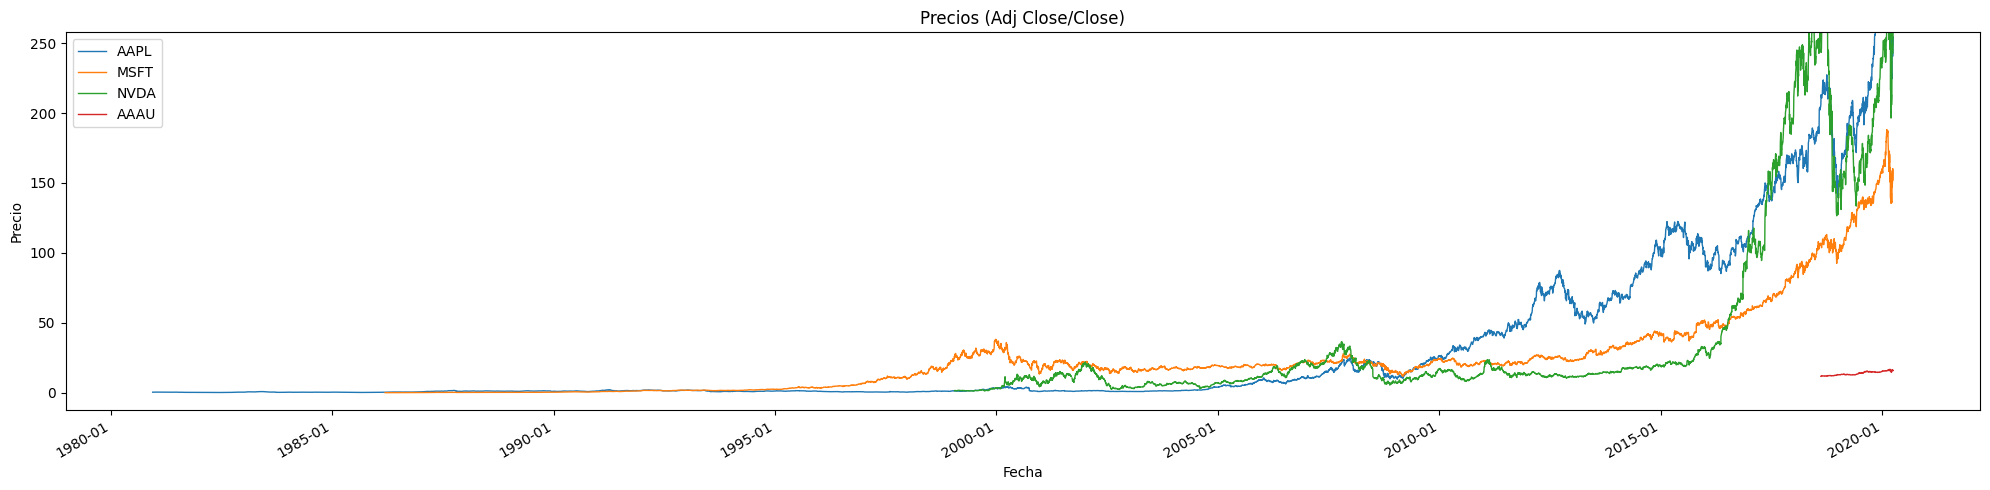

In [80]:
# Series temporales de precios (ajustando escala y tamaño según duración)
import matplotlib.dates as mdates

# Calcular duración total para ajustar el ancho de la figura
all_dates = pd.concat([df['Date'] for df in assets_ret.values() if 'Date' in df.columns and not df['Date'].dropna().empty])
n_days = (all_dates.max() - all_dates.min()).days if len(all_dates) > 0 else 1
fig_w = max(10, min(20, n_days / 30))  # ancho entre 10 y 20

fig, ax = plt.subplots(figsize=(fig_w, 5))
# Construir lista segura de arrays antes de concatenar
prices_list = [df['price'].dropna().to_numpy() for df in assets_ret.values() if 'price' in df.columns and df['price'].dropna().size > 0]
if prices_list:
    all_prices = np.concatenate(prices_list)
else:
    all_prices = np.array([])

# Usar percentiles 1%-99% para fijar límites y evitar outliers extremos
if all_prices.size > 0:
    ylow, yhigh = np.nanpercentile(all_prices, [1, 99])
    ypad = 0.05 * (yhigh - ylow) if (yhigh - ylow) > 0 else (abs(yhigh) * 0.05 if yhigh != 0 else 0.05)
    ax.set_ylim(ylow - ypad, yhigh + ypad)

for sym, df in assets_ret.items():
    if 'Date' in df.columns and 'price' in df.columns:
        ax.plot(df["Date"], df["price"], label=sym, lw=1)

ax.set_title("Precios (Adj Close/Close)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio")
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.tight_layout()
plt.show()

### 2.3. Distribuciones: histogramas y boxplots de rendimientos

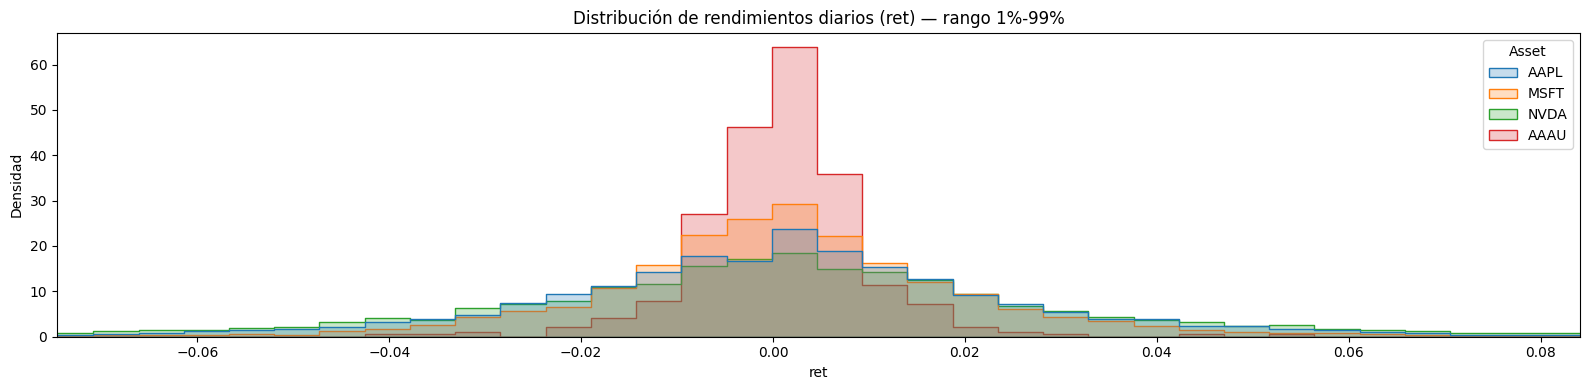

In [81]:
# Histogramas ajustando bins y límites por percentiles
n = len(rets)
fig_w = max(8, min(16, n / 300))
plt.figure(figsize=(fig_w, 4))
# limitar por percentiles para que los outliers no deformen la vista
low, high = rets['ret'].quantile([0.01, 0.99])
# bins dependientes del tamaño de la muestra
bins = int(np.clip(n / 10, 30, 200))

sns.histplot(data=rets, x="ret", hue="Asset", element="step", stat="density", common_norm=False, bins=bins)
plt.xlim(low, high)
plt.title("Distribución de rendimientos diarios (ret) — rango 1%-99%")
plt.xlabel("ret")
plt.ylabel("Densidad")
plt.tight_layout()
plt.show()

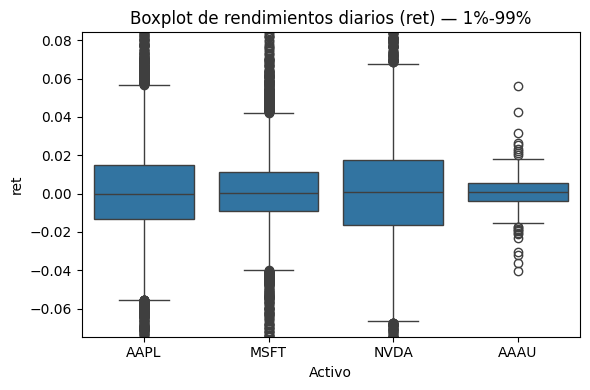

In [82]:
# Boxplot con límites por percentiles y tamaño según número de activos
n_assets = rets['Asset'].nunique()
fig_w = max(6, n_assets * 1.2)
plt.figure(figsize=(fig_w, 4))
low, high = rets['ret'].quantile([0.01, 0.99])
sns.boxplot(data=rets, x="Asset", y="ret")
plt.ylim(low, high)
plt.title("Boxplot de rendimientos diarios (ret) — 1%-99%")
plt.xlabel("Activo")
plt.ylabel("ret")
plt.tight_layout()
plt.show()

### 2.4 Identificación y Análisis de Outliers

Los outliers en series financieras suelen corresponder a eventos de importancia económica o de mercado (shocks) que permiten entender episodios de estrés sistémico y preparar modelos que manejen colas pesadas. Constituyen rendimientos que se desvían significativamente del comportamiento típico de cada activo, identificados mediante el criterio **z-score > 3** (desviaciones superiores a 3 veces la desviación estándar) o el método **IQR** (rango intercuartílico).

In [83]:
# Identificación de outliers mediante z-score e IQR

from scipy.stats import zscore

def identify_outliers(df: pd.DataFrame, column: str, method: str = 'zscore', threshold: float = 3) -> pd.DataFrame:
    if method == 'zscore':
        non_nan_df = df.dropna()
        non_nan_column = non_nan_df[column].dropna()
        z = np.abs(zscore(non_nan_column))
        outliers_mask = z > threshold
        outliers = non_nan_df[outliers_mask].copy()
    elif method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
        outliers_mask = (df[column] < lower) | (df[column] > upper)
        outliers = df[outliers_mask].copy()
    else:
        raise ValueError("method debe ser 'zscore' o 'iqr'")
    
    return outliers.sort_values(column, key=abs, ascending=False)

# Aplicar a rendimientos diarios (usando z-score con threshold=3)
print("=== Outliers en Rendimientos Diarios (z-score > 3) ===\n")

outliers_collection = {}
for sym, df in assets_ret.items():
    outs = identify_outliers(df, 'ret', method='zscore', threshold=3)
    if len(outs) > 0:
        print(f"\n{sym}: {len(outs)} outliers")
        print(outs[['Date','ret','price']].head(10).to_string(index=False))
        outliers_collection[sym] = outs
    else:
        print(f"\n{sym}: sin outliers (z-score > 3)")

# Análisis de eventos extremos en la intersección temporal
try:
    wide = rets.pivot_table(index="Date", columns="Asset", values="ret").dropna()
except Exception as e:
    wide = None

if wide is not None and hasattr(wide, "shape"):
    print(f"\n\nRendimientos más extremos (top 10 por |ret|) en los {wide.shape[0]} días comunes:\n")

    extreme = wide.abs().stack().reset_index()
    extreme.columns = ["Date", "Asset", "abs_ret"]
    extreme = extreme.sort_values("abs_ret", ascending=False).head(10)
    print(extreme.to_string(index=False))

=== Outliers en Rendimientos Diarios (z-score > 3) ===


AAPL: 126 outliers
      Date       ret    price
2000-09-29 -0.518692 1.596575
1997-08-06  0.332278 0.815726
1983-09-23 -0.253846 0.343111
1987-10-19 -0.243523 1.035775
1998-01-02  0.238095 0.503774
1996-07-18  0.237037 0.647155
1993-07-16 -0.230769 0.824564
1987-10-26 -0.211268 0.794567
1998-01-06  0.192913 0.587090
1993-10-15  0.189474 0.850785

MSFT: 122 outliers
      Date       ret      price
1987-10-19 -0.301159   0.201615
2000-10-19  0.195652  19.849651
1987-10-26 -0.186528   0.174882
2008-10-13  0.186046  19.426094
1987-10-21  0.179687   0.252298
1987-10-29  0.157576   0.212754
2000-04-24 -0.155978  21.373466
2020-03-16 -0.147390 135.419998
2000-04-03 -0.144706  29.152929
2020-03-13  0.142169 158.830002

NVDA: 73 outliers
      Date       ret     price
2000-03-07  0.424146  6.389926
2004-08-06 -0.352335  2.893059
2003-05-09  0.330635  6.556170
2002-07-31 -0.317509  3.396200
2008-07-03 -0.307265 11.495540
2001-01-03  0.306

**Resultados por Activo:**

Como era esperado, los más extremos corresponden a fechas históricas de importancia y eventos de estrés sistémico.

- **AAPL:** 126 outliers. Ejemplos: 
    - 2000-09-29 con -51.9%: caída de septiembre 2000 durante el crash de las dot-com 
    - 1987-10-19: "Lunes Negro"

- **MSFT:** 122 outliers. Ejemplos:
    - 2000-09-29 con -51.9%: caída de septiembre 2000 durante el crash de las dot-com 
    - 1987-10-19: "Lunes Negro"
    - 2020-03 con con -14.7%: caída de marzo 2020 por COVID-19

- **NVDA:** 73 outliers. Ejemplos:
    - 2000-03-07 con +42.4%: mayor movimiento extremo positivo (burbuja tecnológica) 
    - 2000-2004: patrones de volatilidad pronunciada por crisis tecnológicas.

- **AAAU (Gold ETF):** Solo 7 outliers, todos concentrados en marzo 2020. El oro actúa como **activo refugio**, mostrando movimientos moderados incluso en periodos de estrés, reflejando su rol de cobertura contra la volatilidad de las acciones.

**Conclusiones:**

El período de análisis (2018-08-15 a 2020-04-01) captura la crisis de COVID-19 de marzo 2020. Los rendimientos más extremos en la intersección temporal son:

- **2018-11-16 (NVDA):** +18.76% — reacción a sorpresas positivas en noticias de tecnología.
- **2020-03-16 (NVDA, MSFT, AAPL):** Máximos globales de volatilidad durante el pánico de mercado por confinamiento global.

Esto confirma que en periodos de estrés sistémico, los outliers se concentran y reflejan cambios abruptos en la demanda de activos de riesgo (acciones) versus activos defensivos (oro). Su identificación permite detectar eventos de importancia económica y preparar modelos estadísticos que manejen adecuadamente colas pesadas en distribuciones financieras.

### 2.5. Correlaciones entre activos (sobre rendimientos)

Creamos una tabla por fecha con rendimientos de cada activo y calculamos la matriz de correlación.

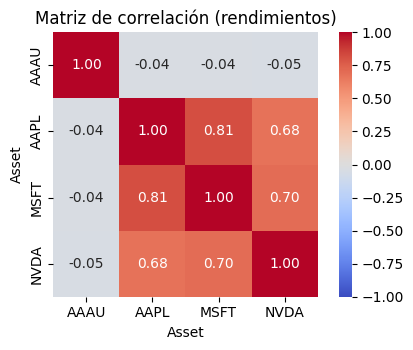

Asset,AAAU,AAPL,MSFT,NVDA
Asset,,,,
AAAU,1.000000,-0.038661,-0.035835,-0.045407
AAPL,-0.038661,1.000000,0.813582,0.676136
MSFT,-0.035835,0.813582,1.000000,0.700779
NVDA,-0.045407,0.676136,0.700779,1.000000


In [84]:
corr = wide.corr()

# Tamaño relativo según número de activos
n_assets = corr.shape[0]
fig_w = max(4, n_assets * 1.2)
fig_h = max(3, n_assets * 0.9)
plt.figure(figsize=(fig_w, fig_h))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm", square=True)
plt.title("Matriz de correlación (rendimientos)")
plt.tight_layout()
plt.show()

corr

---

## 3. Preparación de Datos

Acciones típicas:
- Manejo de valores faltantes (por ejemplo, eliminar fechas sin todos los activos).
- Estandarización (necesaria para PCA y K-Means).
- Construcción de variables para clasificación (sube/baja).

### 3.1. Dataset final para análisis multivariado

Se usarán fechas donde existan rendimientos para todos los activos (intersección).

In [85]:
X = wide.copy()  # shape: (n_days, n_assets)
X.shape, X.head()

((409, 4),
 Asset           AAAU      AAPL      MSFT      NVDA
 Date                                              
 2018-08-16  0.000000  0.014650 -0.000186 -0.006330
 2018-08-17  0.006814  0.019970 -0.000557 -0.049021
 2018-08-20  0.006768 -0.009743 -0.006600  0.012336
 2018-08-21  0.002521 -0.001949 -0.008328  0.022111
 2018-08-22  0.002515  0.000047  0.010190  0.037502)

### 3.2. Estandarización

In [86]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:3]

array([[-0.08643419,  0.59558663, -0.06027656, -0.19425497],
       [ 0.67097317,  0.82209064, -0.0771419 , -1.41063123],
       [ 0.6658469 , -0.44301483, -0.35146687,  0.33758328]])

---

## 4. Aplicación de Técnicas Estadísticas

Se aplicará:

1) **Prueba de hipótesis**: Comparación de medias de rendimientos mediante Welch t-test  
2) **Regresión lineal**: Relación entre rendimientos de dos activos (`MSFT`  y `AAPL`)  
3) **PCA**: Reducción de dimensionalidad / patrones  
4) **Clustering**: K-Means en espacio PCA  
5) **Clasificación**: Regresión logística para predecir el sentido de la varición de un activo


### 4.1. Pruebas de hipótesis: ¿difieren las medias de rendimientos?

Se usará **Welch t-test** dado que no asume varianzas iguales.  
Hipótesis:

- **H0:** la media de rendimientos de A es igual a la media de rendimientos de B  
- **H1:** las medias son diferentes  

Nivel de significancia: $ \alpha = 0.05 $.

In [87]:
alpha = 0.05
assets_list = list(X.columns)

results_t = []
for i in range(len(assets_list)):
    for j in range(i+1, len(assets_list)):
        a, b = assets_list[i], assets_list[j]
        # convert to plain float numpy arrays and align by non-missing pairs
        arr_a = X[a].to_numpy(dtype=float)
        arr_b = X[b].to_numpy(dtype=float)
        mask = ~np.isnan(arr_a) & ~np.isnan(arr_b)
        arr_a = arr_a[mask]
        arr_b = arr_b[mask]

        if arr_a.size < 2 or arr_b.size < 2:
            # insufficient data to perform the test
            results_t.append({
                "A": a, "B": b,
                "t_stat": np.nan,
                "p_value": np.nan,
                "Reject_H0_(alpha=0.05)": False
            })
            continue

        tstat, pval = stats.ttest_ind(arr_a, arr_b, equal_var=False, nan_policy="omit")

        # ensure we store plain Python floats / bools (avoid ndarray/tuple types)
        tstat_f = float(np.asarray(tstat).item())
        pval_f = float(np.asarray(pval).item())
        results_t.append({
            "A": a,
            "B": b,
            "t_stat": tstat_f,
            "p_value": pval_f,
            "Reject_H0_(alpha=0.05)": pval_f < alpha
        })

pd.DataFrame(results_t).sort_values("p_value")

pd.DataFrame(results_t).sort_values("p_value")

,A,B,t_stat,p_value,Reject_H0_(alpha=0.05)
5,MSFT,NVDA,0.318991,0.749831,False
1,AAAU,MSFT,-0.309185,0.757300,False
3,AAPL,MSFT,-0.301276,0.763281,False
2,AAAU,NVDA,0.161772,0.871556,False
0,AAAU,AAPL,0.093214,0.925769,False
4,AAPL,NVDA,0.083277,0.933655,False


#### Resultado:
Las pruebas t de Welch aplicadas a los rendimientos diarios de los activos no mostraron diferencias estadísticamente significativas entre las medias, ya que en todos los casos los valores p fueron mayores que 0.05. Por tanto, no se rechaza la hipótesis nula de igualdad de medias, lo que sugiere que, en el período analizado, los activos presentan rendimientos medios similares.

### 4.2. Regresión lineal: ¿explica MSFT los rendimientos de AAPL?

Modelo: $ \quad r^{AAPL}_t = \beta_0 + \beta_1 r^{MSFT}_t + \varepsilon_t $

In [88]:
# Convert to plain numpy arrays to avoid ExtensionArray / type-check issues
y = X["AAPL"].to_numpy(dtype=float).ravel()
x = X[["MSFT"]].to_numpy(dtype=float)

lr = LinearRegression()
lr.fit(x, y)
pred = lr.predict(x)

# r2_score works with numpy arrays
r2 = r2_score(y, pred)

# Some sklearn versions don't accept the 'squared' kwarg; compute RMSE explicitly
rmse = np.sqrt(mean_squared_error(y, pred))

lr.coef_, lr.intercept_, r2, rmse

(array([0.86752844]),
 np.float64(-0.0003290024135575745),
 0.6619159169362874,
 np.float64(0.01365637987675914))

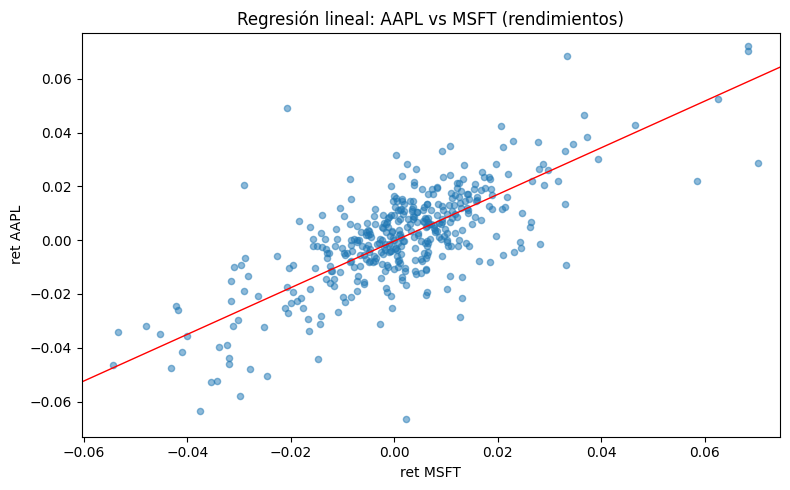

Modelo: AAPL = -0.000329 + 0.868 * MSFT
R² = 0.662 | RMSE = 0.01366


In [89]:
plt.figure(figsize=(8, 5))
plt.scatter(X["MSFT"], X["AAPL"], alpha=0.5, s=20)
# recta de predicción
xs = np.linspace(X["MSFT"].min(), X["MSFT"].max(), 200)
ys = lr.intercept_ + lr.coef_[0] * xs
plt.plot(xs, ys, color='red', lw=1)
plt.title("Regresión lineal: AAPL vs MSFT (rendimientos)")
plt.xlabel("ret MSFT")
plt.ylabel("ret AAPL")
# establecer límites con percentiles 1%-99% y padding
xmin, xmax = X["MSFT"].quantile([0.01, 0.99])
ymin, ymax = X["AAPL"].quantile([0.01, 0.99])
xpad = (xmax - xmin) * 0.05
ypad = (ymax - ymin) * 0.05
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)
plt.tight_layout()
plt.show()

print(f"Modelo: AAPL = {lr.intercept_:.6f} + {lr.coef_[0]:.3f} * MSFT")
print(f"R² = {r2:.3f} | RMSE = {rmse:.5f}")

#### Resultado:
El gráfico de regresión lineal entre los rendimientos de AAPL y MSFT muestra una relación positiva clara. La pendiente estimada indica que los rendimientos de ambos activos tienden a moverse en la misma dirección, reflejando una fuerte dependencia lineal, aunque con variabilidad atribuible a factores externos.

### 4.3. PCA: reducción de dimensionalidad y patrones

Se aplicará PCA sobre rendimientos estandarizados.

In [90]:
pca = PCA(n_components=min(4, X.shape[1]))
Z = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
pd.DataFrame({"Componente": [f"PC{i+1}" for i in range(len(explained))],
              "Varianza_Explicada": explained,
              "Varianza_Acumulada": np.cumsum(explained)})

,Componente,Varianza_Explicada,Varianza_Acumulada
0,PC1,0.616318,0.616318
1,PC2,0.249218,0.865536
2,PC3,0.088189,0.953724
3,PC4,0.046276,1.000000


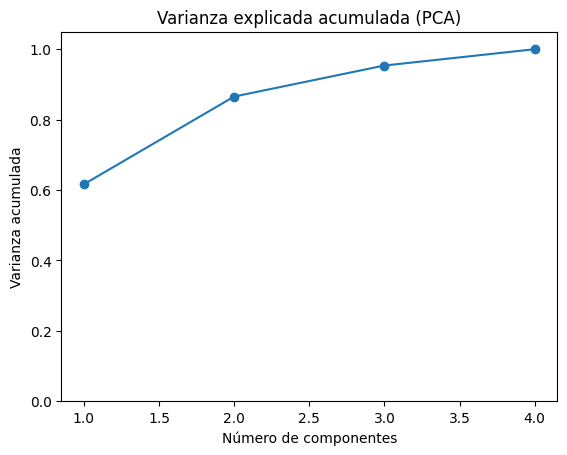

In [91]:
plt.figure()
plt.plot(np.arange(1, len(explained)+1), np.cumsum(explained), marker="o")
plt.title("Varianza explicada acumulada (PCA)")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.ylim(0, 1.05)
plt.show()

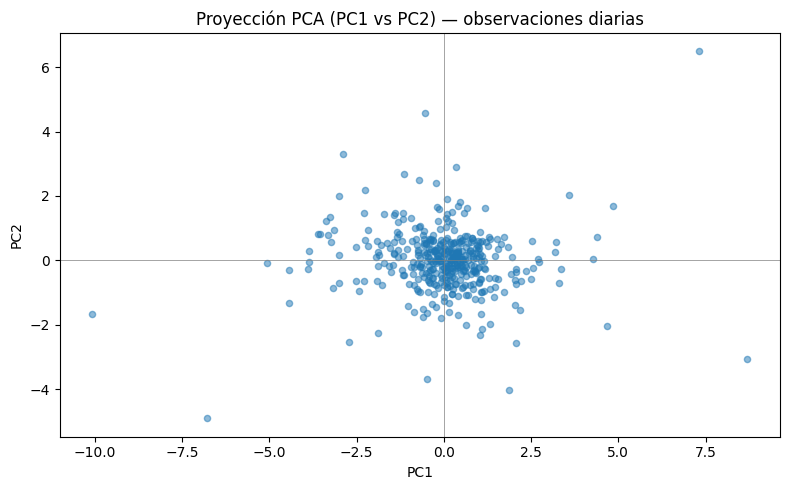

In [92]:
# Visualización 2D (PC1 vs PC2)
if Z.shape[1] >= 2:
    fig_w = max(8, min(14, Z.shape[0] / 200))
    plt.figure(figsize=(fig_w, 5))
    plt.scatter(Z[:, 0], Z[:, 1], alpha=0.5, s=20)
    plt.title("Proyección PCA (PC1 vs PC2) — observaciones diarias")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.tight_layout()
    plt.show()

#### Resultado:
La proyección PCA de las observaciones diarias muestra que la primera componente principal concentra la mayor parte de la variabilidad, reflejando un factor común de mercado que afecta simultáneamente a los activos analizados. La mayoría de los días se agrupan cerca del origen, mientras que los puntos alejados corresponden a episodios de alta volatilidad.

### 4.4. Clustering: K-Means en el espacio PCA

Se utilizarán las 2 primeras componentes para agrupar días con comportamiento similar.

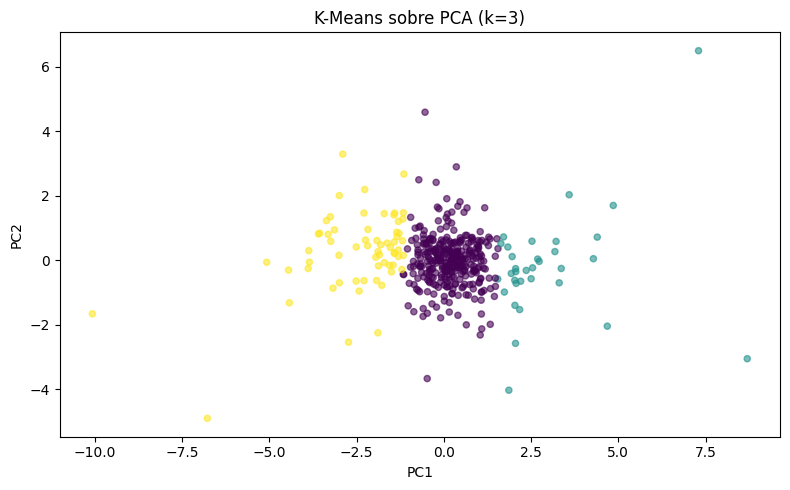

0    313
1     33
2     63
Name: count, dtype: int64

In [93]:
if Z.shape[1] >= 2:
    Z2 = Z[:, :2]
else:
    Z2 = Z

# Elegimos k=3 por simplicidad (puedes explorar con elbow)
k = 3
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = kmeans.fit_predict(Z2)

fig_w = max(8, min(14, Z2.shape[0] / 200))
plt.figure(figsize=(fig_w, 5))
if Z2.shape[1] >= 2:
    plt.scatter(Z2[:, 0], Z2[:, 1], c=labels, alpha=0.6, s=20)
    plt.title("K-Means sobre PCA (k=3)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
else:
    plt.scatter(np.arange(len(Z2)), Z2[:, 0], c=labels, alpha=0.6, s=20)
    plt.title("K-Means (1D)")
    plt.xlabel("Índice")
    plt.ylabel("PC1")
plt.tight_layout()
plt.show()

pd.Series(labels).value_counts().sort_index()

### 4.4.1 Caracterización del resultado
El clustering K-Means aplicado sobre las componentes principales identifica tres grupos de días con comportamientos similares. Un cluster central agrupa días de baja variación, mientras que los otros dos corresponden a días con movimientos positivos y negativos más pronunciados del mercado, evidenciando distintos regímenes de comportamiento.

Además del tamaño, es informativo examinar las propiedades de cada cluster para entender qué los diferencia 
estadísticamente. Por ejemplo, podemos calcular la volatilidad media y correlación media dentro de cada cluster, 
identificando si uno representa "alta volatilidad" y otro "baja correlación" o "movimientos anómalos".

In [94]:
# Caracterización estadística de cada cluster

print("=== Caracterización de Regímenes (Clusters) ===\n")

# Agregar etiquetas de cluster al dataframe
wide_with_cluster = wide.copy()
wide_with_cluster['cluster'] = labels

for cluster_id in sorted(np.unique(labels)):
    mask = wide_with_cluster['cluster'] == cluster_id
    cluster_data = wide_with_cluster[mask].drop(columns=['cluster'])
    
    print(f"CLUSTER {cluster_id} ({mask.sum()} días, {mask.sum()/len(labels)*100:.1f}%)")
    
    # Media de volatilidad en el cluster
    vol_in_cluster = cluster_data.std()
    print(f"\nVolatilidad media por activo:")
    print(vol_in_cluster.round(5).to_string())
    
    # Correlación media dentro del cluster
    if cluster_data.shape[0] > 1:
        corr_in_cluster = cluster_data.corr()
        corr_in_cluster_mean = corr_in_cluster.values[np.triu_indices_from(corr_in_cluster.values, k=1)].mean()
        print(f"\nCorrelación media (entre pares diferentes): {corr_in_cluster_mean:.4f}")
    
    # Retorno medio
    ret_mean = cluster_data.mean()
    print(f"\nRetorno promedio por activo:")
    print(ret_mean.round(6).to_string())
    
    # Extremos
    print(f"\nRetorno mínimo y máximo observados:")
    print(f"  Mínimo: {cluster_data.min().min():.6f}")
    print(f"  Máximo: {cluster_data.max().max():.6f}")
    
    print(f"\n{'='*60}")

=== Caracterización de Regímenes (Clusters) ===

CLUSTER 0 (313 días, 76.5%)

Volatilidad media por activo:
Asset
AAAU    0.00746
AAPL    0.01139
MSFT    0.00973
NVDA    0.01949

Correlación media (entre pares diferentes): 0.1202

Retorno promedio por activo:
Asset
AAAU    0.000436
AAPL    0.003401
MSFT    0.003059
NVDA    0.004374

Retorno mínimo y máximo observados:
  Mínimo: -0.049021
  Máximo: 0.070205

CLUSTER 1 (33 días, 8.1%)

Volatilidad media por activo:
Asset
AAAU    0.01529
AAPL    0.02658
MSFT    0.02851
NVDA    0.03046

Correlación media (entre pares diferentes): 0.3903

Retorno promedio por activo:
Asset
AAAU   -0.002441
AAPL    0.039790
MSFT    0.040492
NVDA    0.057405

Retorno mínimo y máximo observados:
  Mínimo: -0.036152
  Máximo: 0.171564

CLUSTER 2 (63 días, 15.4%)

Volatilidad media por activo:
Asset
AAAU    0.01075
AAPL    0.02421
MSFT    0.02322
NVDA    0.03850

Correlación media (entre pares diferentes): 0.4230

Retorno promedio por activo:
Asset
AAAU    0.004

#### **Cluster 0: Régimen "Normal" (76.5% de los días, 313 observaciones)**

- **Volatilidad:** Baja - Moderada
- **Correlación media entre activos:** Muy baja, los activos se mueven independientemente
- **Retornos promedio:** Positivos pero moderados
- **Rango de retorno:** [-4.9%, +7.0%] $ \to $ movimientos contenidos y predecibles
- **Interpretación:** Representa el comportamiento típico de mercado bajo condiciones de estabilidad relativa donde la diversificación funciona óptimamente. La baja correlación indica que los activos responden a factores idiosincráticos (noticias de empresa individual). El oro (AAAU) exhibe el menor movimiento, reflejando su papel defensivo.

#### **Cluster 1: Régimen de "Rally" o "Euforia" (8.1% de los días, 33 observaciones)**

- **Volatilidad:** Moderada - Alta
- **Correlación media entre activos:** Moderada, los activos se mueven conjuntamente
- **Retornos promedio:** Fuertemente positivos
- **Rango:** [-3.6%, +17.2%] $ \to $ máximos potentes, mínimos contenidos
- **Interpretación:** Períodos de movimientos alcistas coordinados y mayor sincronía de mercado; días de "risk-on" donde los inversores compran activos de riesgo (acciones) con confianza. Todos los sectores tecnológicos suben coordinadamente (+4% a +5.7% promedio). Nótese que el oro baja levemente (−0.24%), en un patrón contrario a su característica de activo refugio. Solo 33 días (~8%) son así, sugiriendo períodos breves de euforia de mercado.

#### **Cluster 2: Régimen de "Crash" o "Estrés" (15.4% de los días, 63 observaciones)**

- **Volatilidad:** Muy alta (aparece en NVDA la volatilidad más alta registrada con 3.85%)
- **Correlación media entre activos:** Más alta que que los otros regímenes, los activos se ven afectados en conjunto
- **Retornos promedio:** Fuertemente negativos
- **Rango:** [-18.8%, +3.2%] $ \to $ caídas extremas, recuperaciones limitadas
- **Interpretación:** Días de "risk-off" donde inversores venden activos de riesgo en pánico sistémico y el mercado experimenta correcciones profundas. Las tres acciones de empresas tecnológicas caen coordinadamente (−3% a −5% promedio), mientras el oro sube ligeramente (+0.42%) por el efecto de activo refugio. La correlación aumenta a 0.42 porque todos huyen simultáneamente hacia oro/efectivo. NVDA sufre la caída más severa (−4.86% promedio), evidenciando su mayor exposición a ciclos de riesgo.

#### **Conclusiones**

1. **Predominio de normalidad:** 76.5% de los días operan bajo el régimen "normal", permitiendo estrategias de diversificación estándar.

2. **Correlación dinámica:** La correlación entre activos aumenta dramáticamente en estrés (0.12 → 0.42), reduciendo el beneficio de diversificación precisamente cuando más se necesita protección. Este fenómeno es crítico en gestión de riesgo.

3. **El oro como cobertura:** AAAU demuestra su función de "safe haven":
   - Gana en estrés (Cluster 2: +0.42%)
   - Pierde en euforia (Cluster 1: −0.24%)
   - Neutral en normalidad (Cluster 0: +0.04%)

4. **Asimetría de riesgo:** El cluster de crash (15.4%) es mayor en frecuencia que el de rally (8.1%) y más severo en magnitud (min −18.8% vs. max +17.2%), evidenciando la "asimetría de colas" característica de mercados financieros.

### 4.5. Clasificación: regresión logística para predecir el sentido de variación de un activo (ejemplo con AAPL)

Definimos variable objetivo: $ \quad y_t = \mathbb{1}[r^{AAPL}_t > 0] $

Features: rendimientos de los otros activos (MSFT, NVDA, AAAU) del mismo día.
> Nota: esto es una aproximación simple y no necesariamente realista en trading, pero sirve como ejercicio estadístico de clasificación.

In [95]:
df_cls = X.copy()
df_cls["y_up_AAPL"] = (df_cls["AAPL"] > 0).astype(int)

features = [c for c in df_cls.columns if c not in ["AAPL","y_up_AAPL"]]
# use to_numpy(...) to ensure plain numpy arrays (satisfies type checkers)
Xc = df_cls[features].to_numpy(dtype=float)
yc = df_cls["y_up_AAPL"].to_numpy(dtype=int).ravel()

X_train, X_test, y_train, y_test = train_test_split(
	Xc, yc, test_size=0.25, random_state=42, stratify=yc
)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [96]:
print("Accuracy:", acc)
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte:\n", classification_report(y_test, y_pred, digits=3))

Accuracy: 0.5922330097087378

Matriz de confusión:
 [[ 5 42]
 [ 0 56]]

Reporte:
               precision    recall  f1-score   support

           0      1.000     0.106     0.192        47
           1      0.571     1.000     0.727        56

    accuracy                          0.592       103
   macro avg      0.786     0.553     0.460       103
weighted avg      0.767     0.592     0.483       103



In [97]:
# Ejemplo de "volatilidad" como desviación estándar de rendimientos
vol = X.std().sort_values(ascending=False)
vol

Asset
NVDA    0.035140
AAPL    0.023516
MSFT    0.022053
AAAU    0.009008
dtype: float64

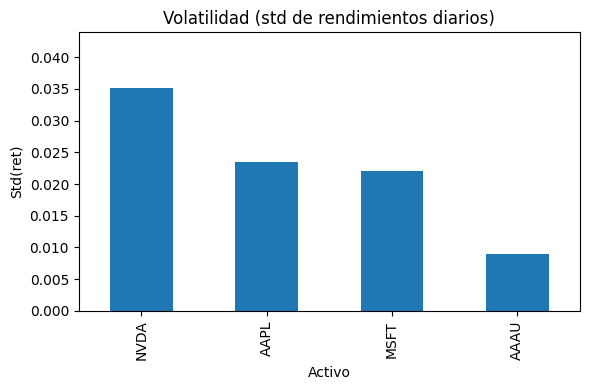

In [98]:
fig_w = max(6, len(vol) * 1.2)
plt.figure(figsize=(fig_w, 4))
ax = vol.plot(kind="bar")
ax.set_title("Volatilidad (std de rendimientos diarios)")
ax.set_xlabel("Activo")
ax.set_ylabel("Std(ret)")
ymax = vol.max()
if np.isfinite(ymax) and ymax > 0:
    ax.set_ylim(0, ymax * 1.25)
plt.tight_layout()
plt.show()

---

## ✅ Resultados



## 📌 Conclusiones


## 🧾 Referencias
- **Downey, A. B.** — *Think Stats: Probability and Statistics for Programmers*. Disponible en línea: https://greenteapress.com/wp/think-stats-2e/
- **Casella, G. & Berger, R. L.** — *Statistical Inference* (2024). Información editorial: https://www.wiley.com/en-us/Statistical+Inference%2C+2nd+Edition-p-9780534267710
- **Hogg, R. V. & Craig, A. T.** — *Introduction to Mathematical Statistics* (2019). Información editorial: https://www.pearson.com/
- **Wackerly, D., Mendenhall, W. & Scheaffer, R.** — *Mathematical Statistics / Estadística* (7ª ed., 2010). Información editorial: https://www.cengage.com/
- **Documentación de las librerías utilizadas**

    - **NumPy:** https://numpy.org/doc/
    - **pandas:** https://pandas.pydata.org/docs/
    - **Matplotlib:** https://matplotlib.org/stable/contents.html
    - **Seaborn:** https://seaborn.pydata.org/
    - **SciPy:** https://docs.scipy.org/doc/scipy/reference/
    - **scikit-learn:** https://scikit-learn.org/stable/documentation.html